### Imports

In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FourierBasis
from skfda.ml.regression import LinearRegression

plt.style.use("seaborn-v0_8-colorblind")

CSV_PATH = "../original_data/clean_data.csv"

df = pd.read_csv(CSV_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])

# windows
PREV_WEEK_START = pd.Timestamp("2024-06-06 00:00:00")
PREV_WEEK_END   = pd.Timestamp("2024-06-12 23:00:00")
TARGET_START    = pd.Timestamp("2024-06-13 00:00:00")
TARGET_END      = pd.Timestamp("2024-06-19 23:00:00")

In [2]:
def build_features(frame: pd.DataFrame) -> pd.DataFrame:
    gen_cols_for_total = [
        "biomass",
        "brown_coal/lignite",
        "coal_derived_gas",
        "natural_gas",
        "hard_coal",
        "oil",
        "hydro_run_of_river",
        "hydro_water_reservoir",
        "solar",
        "wind",
    ]
    out = frame.copy()
    out["net_load"] = out["day_ahead_load_forecast"] - out["wind"] - out["solar"]
    total_gen = out[gen_cols_for_total].sum(axis=1, min_count=1)
    out["renewable_share"] = ((out["solar"] + out["wind"]) / total_gen).clip(lower=0, upper=1)
    out["conventional_gen"] = out["hard_coal"] + out["natural_gas"] + out["brown_coal/lignite"]
    out["ngas_price_eur_mwh"] = out["natural_gas_eur/mwh"]
    out["coal_price_eur_ton"] = out["coal_eur/ton"]
    out["co2_price_eur_ton"]  = out["co2_eur/ton"]
    out["interconnection_share"] = out["trade_balance"] / out["day_ahead_load_forecast"]
    cols = [
        "datetime",
        "day_ahead_price_eur",
        "net_load",
        "renewable_share",
        "conventional_gen",
        "ngas_price_eur_mwh",
        "coal_price_eur_ton",
        "co2_price_eur_ton",
        "interconnection_share",
    ]
    return out[cols]

In [3]:
def _fd_eval(fd, t):
    return np.asarray(fd(t)).squeeze()

### Build Train Dataset

#### A. Load & Generation Data

1. net_load = load - wind - solar
2. renewable_share = (wind + solar) / load
3. conventional_gen = coal + gas + lignite

#### B. Fuel & Policy Data

1. ngas_price_eur_mwh
2. coal_price_eur_ton
3. co2_price_eur_ton

#### Interconnection Data

1. trade_balance / load

In [4]:
train_mask = ~((df["datetime"] >= TARGET_START) & (df["datetime"] <= TARGET_END))
train_df = build_features(df.loc[train_mask].copy())
train_df.to_csv(Path("train_set.csv"), index=False)

### Build Test Set

In [5]:
prev_week = df[(df["datetime"] >= PREV_WEEK_START) & (df["datetime"] <= PREV_WEEK_END)].copy()
prev_week["datetime"] = prev_week["datetime"] + pd.Timedelta(days=7)
hours = prev_week["datetime"].dt.hour

In [6]:
# scenario: solar +10%, wind +210 MW
prev_week["solar"] = prev_week["solar"] * 1.10
prev_week["wind"]  = prev_week["wind"] + 210.0

In [7]:
# scenario: distribute +15% load across ALL nights 00–06 with a smooth taper
shape = np.array([0.6, 0.85, 1.0, 1.1, 1.0, 0.85, 0.6], dtype=float)
shape = shape / shape.mean()                 # mean 1 across the 7 night hours
mean_uplift_per_night = 0.15 / 7.0           # spread the 15% over the 7 nights
night_multipliers = 1.0 + mean_uplift_per_night * shape
mult_by_hour = {h: night_multipliers[i] for i, h in enumerate(range(0,7))}
load_mult = np.ones(len(prev_week), dtype=float)
for h, m in mult_by_hour.items():
    load_mult[hours == h] = m
prev_week["day_ahead_load_forecast"] = prev_week["day_ahead_load_forecast"] * load_mult

In [8]:
# build test features; set price to NaN
test_df = build_features(prev_week)
test_df["day_ahead_price_eur"] = np.nan
test_df = test_df[(test_df["datetime"] >= TARGET_START) & (test_df["datetime"] <= TARGET_END)]
test_df.to_csv(Path("test_set.csv"), index=False)

### Build Functional Concurent Model

In [9]:
TRAIN_CSV = "train_set.csv"
TS_COL    = "datetime"
Y_COL     = "day_ahead_price_eur"
X_COLS    = [
    "net_load",
    "renewable_share",
    "conventional_gen",
    "ngas_price_eur_mwh",
    "coal_price_eur_ton",
    "co2_price_eur_ton",
    "interconnection_share",
]
LABELS = ["Net load","RES share","Conventional gen","Gas €","Coal €","CO₂ €","Interconnection"]
N_BASIS = 9

In [10]:
df = pd.read_csv(TRAIN_CSV, parse_dates=[TS_COL])
d = df[[TS_COL, Y_COL] + X_COLS].copy()
d["day"] = d[TS_COL].dt.floor("D")
d["h"]   = d[TS_COL].dt.hour

In [11]:
def to_day_hour_matrix(frame: pd.DataFrame, col: str) -> pd.DataFrame:
    """Rows = day (one sample per day), Cols = hour 0..23"""
    mat = frame.pivot_table(index="day", columns="h", values=col, aggfunc="mean")
    return mat.reindex(columns=range(24))  # ensure 0..23 exist

In [12]:
Yw = to_day_hour_matrix(d, Y_COL)
Xw_list = [to_day_hour_matrix(d, c) for c in X_COLS]

good_idx = Yw.dropna(how="any").index
for Xw in Xw_list:
    good_idx = good_idx.intersection(Xw.dropna(how="any").index)

Yw = Yw.loc[good_idx]
Xw_list = [Xw.loc[good_idx] for Xw in Xw_list]

# centering
Xw_list_c = [Xw - Xw.mean(axis=0) for Xw in Xw_list]


In [13]:
# Around 3 minutes to train on my m4 mac mini.
grid = np.arange(24, dtype=float)
Y_g = FDataGrid(Yw.values, grid_points=grid)
X_g_list = [FDataGrid(Xw.values, grid_points=grid) for Xw in Xw_list_c]

basis = FourierBasis(domain_range=(0.0, 24.0), n_basis=N_BASIS)
Y_b = Y_g.to_basis(basis)                    # basis for Y (can reuse same for convenience)
X_b_list = [Xg.to_basis(basis) for Xg in X_g_list]

model = LinearRegression(coef_basis=[basis]*len(X_b_list), fit_intercept=True)
model.fit(X_b_list, Y_b)

LinearRegression(coef_basis=[FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0),
                             FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0),
                             FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0),
                             FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0),
                             FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0),
                             FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0),
                             FourierBasis(domain_range=((0.0, 24.0),), n_basis=9, period=24.0)])

#### Save Coefficients of Predictors

In [14]:
cols = ["intercept"] + LABELS
fds  = [model.intercept_] + list(model.coef_)

bw = pd.DataFrame({"basis_index": np.arange(basis.n_basis, dtype=int)})
for name, fd in zip(cols, fds):
    bw[name] = fd.coefficients.ravel()

bw.to_csv("model_basis_weights.csv", index=False)
bw

,basis_index,intercept,Net load,RES share,Conventional gen,Gas €,Coal €,CO₂ €,Interconnection
0,0,632.148768,0.016407,-535.426597,0.008069,2.698762,0.549262,5.210751,19.331672
1,1,-60.680862,0.005921,272.697811,0.004513,-0.831997,0.262702,-0.297115,-157.065928
2,2,-13.690739,0.012116,-196.557247,-0.023462,0.103695,-0.343609,-0.351219,-353.043066
3,3,14.639079,0.002651,23.315869,-0.000343,0.195965,0.221292,-0.400283,60.940792
4,4,-75.524904,-0.006475,11.298437,0.008026,-0.984428,-0.010459,-0.154536,-186.476799
5,5,6.904861,0.005336,-154.244593,-0.009064,0.237100,-0.088846,-0.149201,-125.333589
6,6,7.804677,-0.014259,-14.044811,0.015882,0.038075,0.113454,0.015491,294.975729
7,7,-8.571530,-0.001236,17.195685,0.001762,-0.126121,0.028302,0.039458,-43.555875
8,8,16.956647,-0.002290,-36.388606,0.001976,0.280721,0.065864,-0.079954,39.449456


#### Evaluate

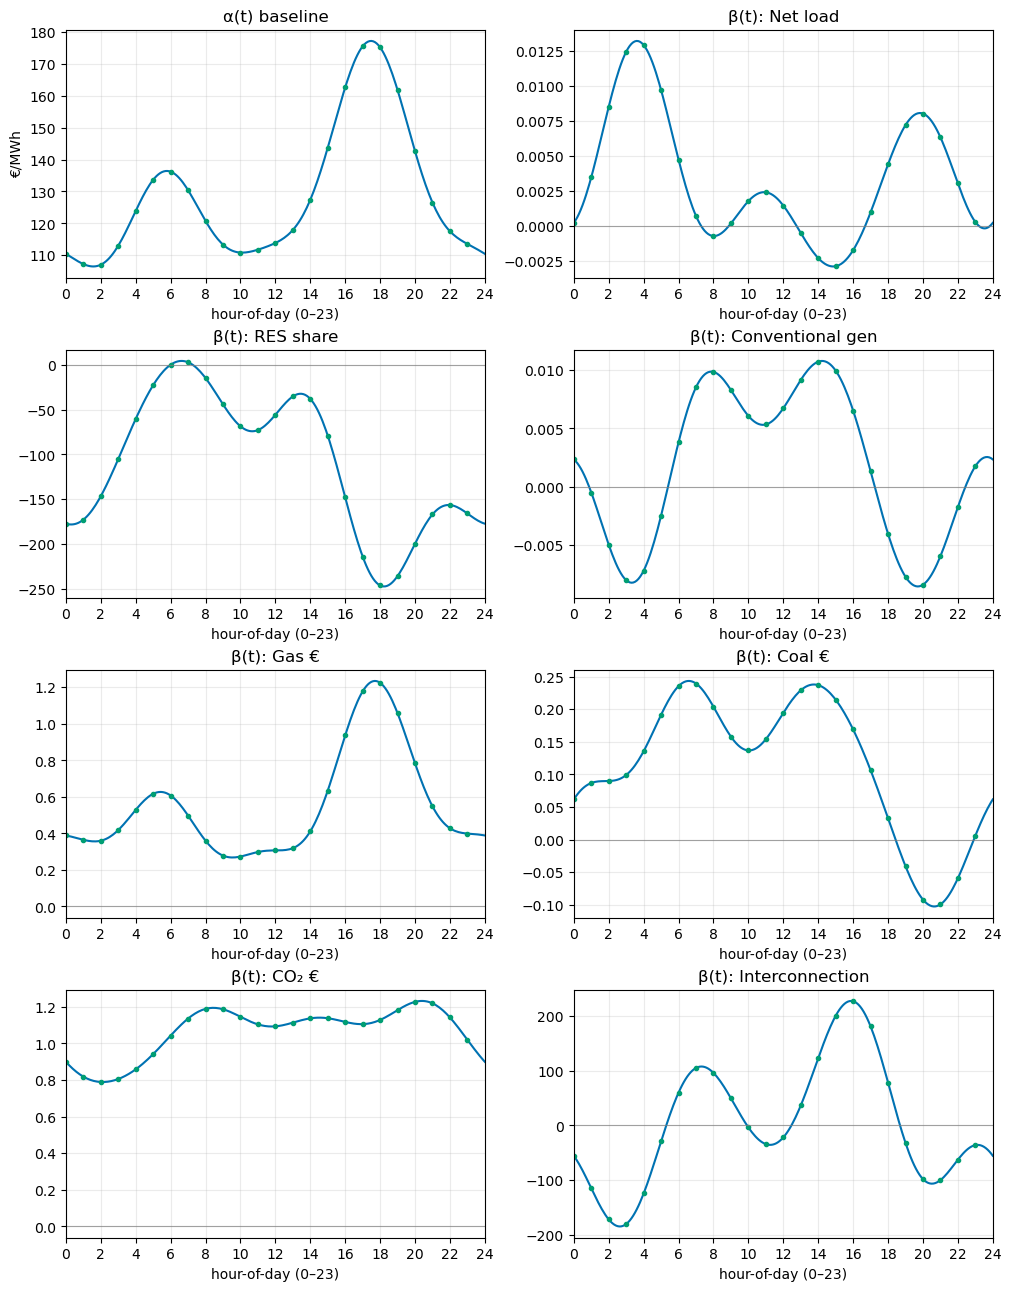

In [15]:
t_int  = np.arange(24)
t_fine = np.linspace(0, 24, 241)
alpha      = _fd_eval(model.intercept_, t_int)
alpha_fine = _fd_eval(model.intercept_, t_fine)
betas      = [_fd_eval(b, t_int)  for b in model.coef_]
betas_fine = [_fd_eval(b, t_fine) for b in model.coef_]

# ---------- plot β-curves (and α) ----------
n_panels = 1 + len(betas)
ncols = 2
nrows = int(np.ceil(n_panels / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3.2*nrows), constrained_layout=True)
axes = np.atleast_1d(axes).ravel()

# α(t)
ax = axes[0]
ax.plot(t_fine, alpha_fine); ax.plot(t_int, alpha, 'o', ms=3)
ax.set_title("α(t) baseline"); ax.set_xlabel("hour-of-day (0–23)"); ax.set_ylabel("€/MWh")
ax.set_xlim(0, 24); ax.set_xticks(range(0, 25, 2)); ax.grid(True, alpha=.25)

# β_j(t)
for j, (lbl, b_f, b_i) in enumerate(zip(LABELS, betas_fine, betas), start=1):
    ax = axes[j]
    ax.plot(t_fine, b_f); ax.plot(t_int, b_i, 'o', ms=3)
    ax.axhline(0, color="grey", lw=0.8, alpha=.7)
    ax.set_title(f"β(t): {lbl}"); ax.set_xlabel("hour-of-day (0–23)")
    ax.set_xlim(0, 24); ax.set_xticks(range(0, 25, 2)); ax.grid(True, alpha=.25)

# blank any extra axes
for k in range(n_panels, len(axes)):
    axes[k].axis("off")

plt.show()

**Concurrent functional linear model (hour-of-day)**  
For each day we model the 24-hour price curve. For hour $t\in\{0,\dots,23\}$:
$$
P(t)=\alpha(t)+\sum_{j=1}^p \beta_j(t)\,X_j(t)+\varepsilon(t),
$$
where $X_j(t)$ are engineered hourly covariates (net load, RES share, fuels, interconnection, …). The $\beta_j(t)$ are hour-specific pass-throughs at the *same* hour $t$.

**Basis representation (Fourier on $[0,24]$)**  
We impose smooth structure by expanding
$$
\alpha(t)\approx\sum_{k=1}^{K} a_k\,\phi_k(t), \qquad
\beta_j(t)\approx\sum_{k=1}^{K} b_{jk}\,\phi_k(t),
$$
with $\phi_k$ low-order Fourier functions (constant + sine/cosine pairs, period 24h). A small $K$ (e.g., $K=9$) captures morning/evening patterns without overfitting.

**Fitting & prediction (summary)**  
1. Reshape to matrices: rows = days, columns = hours $0{:}23$.  
2. Center predictors per hour so $\alpha(t)$ is the baseline at mean hourly profiles.  
3. Project response/predictors onto the Fourier basis and estimate coefficients by least squares.  
4. For forecasting, plug the target week’s hourly $X_j(t)$ into the fitted model to get $\hat P(t)$. We then average over $t$ for daily means.

**Interpretation**  
$\alpha(t)$: baseline price profile at hour $t$.  
$\beta_j(t)$: marginal effect of $X_j(t)$ on price at hour $t$.

**Limitations (from the concurrent choice)**  
- No lag/lead: effects are instantaneous, hence cross-hour dynamics omitted.  
- Basis truncation: smoother curves may miss sharp spikes.  

**Natural extensions**  
- Choose a different model than the concurent one such as the short-term feed forward or the local influence, to allow for input at time $s$ ($s \in [0 \dots 23]$) to influence the price at time $t$.  
- Penalized splines/regularization to tune smoothness and stabilize estimates.

### Prediction

In [16]:
test = pd.read_csv("test_set.csv", parse_dates=[TS_COL])
test["day"] = test[TS_COL].dt.floor("D")
test["h"]   = test[TS_COL].dt.hour

Xtw_list = [to_day_hour_matrix(test, c) for c in X_COLS]
Xtw_list = [X.reindex(columns=range(24)) for X in Xtw_list] # align 0...23 columns
train_hour_means = [to_day_hour_matrix(d, c).reindex(columns=range(24)).mean(axis=0) for c in X_COLS] # to center as the train_set

good_days = Xtw_list[0].dropna(how="any").index
for X in Xtw_list[1:]:
    good_days = good_days.intersection(X.dropna(how="any").index)

Xtw_list = [X.loc[good_days] for X in Xtw_list]
Xtw_list_c = [X - m for X, m in zip(Xtw_list, train_hour_means)]

In [17]:
grid = np.arange(24, dtype=float)
X_test_fd = [FDataGrid(X.values, grid_points=grid).to_basis(basis) for X in Xtw_list_c]

Y_pred_basis = model.predict(X_test_fd)
Y_pred_grid  = Y_pred_basis.to_grid(grid_points=grid)

In [18]:
yhat_hourly = _fd_eval(Y_pred_grid, grid)
yhat_daily  = yhat_hourly.mean(axis=1)

pred_df = pd.DataFrame({
    "day": pd.to_datetime(good_days),
    "pred_day_ahead_price_eur": yhat_daily
}).reset_index(drop=True)

pred_df.to_csv("predictions_daily.csv", index=False)
pred_df

,day,pred_day_ahead_price_eur
0,2024-06-13,93.254373
1,2024-06-14,95.603819
2,2024-06-15,54.880810
3,2024-06-16,57.964305
4,2024-06-17,94.835477
5,2024-06-18,68.475608
6,2024-06-19,85.202874


#### Plot

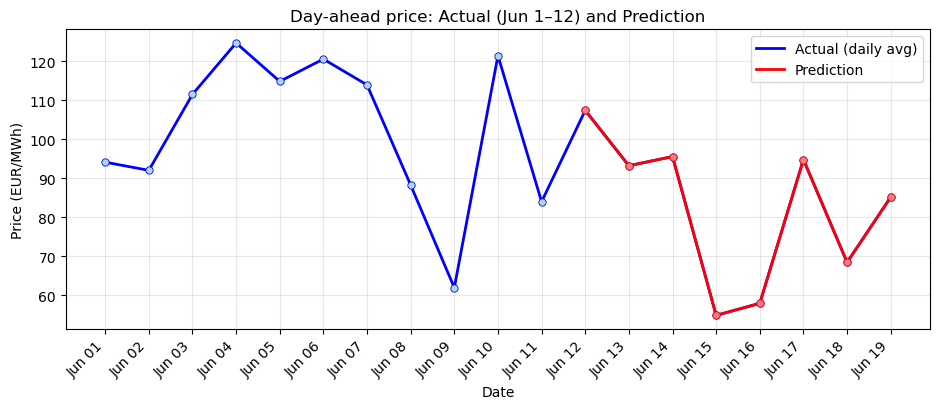

In [19]:
train = pd.read_csv("train_set.csv", parse_dates=[TS_COL])
train["day"] = train[TS_COL].dt.floor("D")
actual_daily = (
    train[(train["day"] >= "2024-06-01") & (train["day"] <= "2024-06-12")]
    .groupby("day", as_index=False)["day_ahead_price_eur"]
    .mean()
    .rename(columns={"day_ahead_price_eur": "value"})
)

pred = pred_df.copy()
pred["day"] = pd.to_datetime(pred["day"]).dt.floor("D")
pred = pred.sort_values("day").rename(columns={"pred_day_ahead_price_eur": "value"})

combined = pd.concat([actual_daily, pred], ignore_index=True).drop_duplicates("day")
combined = combined.sort_values("day")
split_day = pred["day"].min()

fig, ax = plt.subplots(figsize=(9.5, 4.2))

ax.plot(combined["day"], combined["value"], linewidth=2, color="blue", label="Actual (daily avg)")
ax.scatter(combined["day"], combined["value"], s=28, facecolor="lightblue",
           edgecolor="blue", linewidths=0.6, zorder=3)

idx_start = combined.index[combined["day"] >= split_day][0]
seg_red = combined.iloc[idx_start-1:] if idx_start > 0 else combined.iloc[idx_start:]
ax.plot(seg_red["day"], seg_red["value"], linewidth=2, color="red", label="Prediction")
ax.scatter(seg_red["day"], seg_red["value"], s=28, facecolor="lightcoral",
           edgecolor="red", linewidths=0.6, zorder=4)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))  # e.g., "Jun 01"
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")

ax.set_title("Day-ahead price: Actual (Jun 1–12) and Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR/MWh)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()